In [1]:
import os, sys
import torch, json
import numpy as np

from attack_dino import build_model_main
from dino_utils.slconfig import SLConfig
from dataset_utils.coco import build_dataset
from dino_utils.visualizer import COCOVisualizer
from dino_utils import box_ops
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
model_config_path = "dino_utils/config/DINO/DINO_4scale_swin.py"
model_checkpoint_path = "model_files/checkpoint0011_4scale_swin.pth"

In [3]:
args = SLConfig.fromfile(model_config_path) 
args.device = 'cuda' 
model, criterion, postprocessors = build_model_main(args)
checkpoint = torch.load(model_checkpoint_path, map_location='cpu')
model.criterion = criterion
model.postprocessors = postprocessors
_ = model.eval()
model.load_state_dict(checkpoint['model'])
model.to(torch.device('cuda'))
# load coco names
with open('dino_utils/coco_id2name.json') as f:
    id2name = json.load(f)
    id2name = {int(k):v for k,v in id2name.items()}
    
args.dataset_file = 'coco'
args.coco_path = "datasets/coco/" # the path of coco
args.fix_size = False

dataset_val = build_dataset(image_set='val', args=args)   

/home/hice1/zyahn3/.conda/envs/AFOG/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


use_checkpoint!!!!!!!!!!!!!!!!!!!!!!!!


/home/hice1/zyahn3/.conda/envs/AFOG/lib/python3.12/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789220573/work/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/scratch/918650/ipykernel_4041030/2038940770.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mo

loading annotations into memory...
Done (t=0.38s)
creating index...
index created!


In [18]:
# Visualize the ground-truth labels
def viz_gt(image, targets):
    box_label = [id2name[int(item)] for item in targets['labels']]
    gt_dict = {
        'boxes': targets['boxes'],
        'image_id': targets['image_id'],
        'size': targets['size'],
        'box_label': box_label,
    }
    vslzr = COCOVisualizer()
    vslzr.visualize(image, gt_dict, savedir=None, caption="Ground Truth")

# Visualize model predictions
def viz_preds(model, image, targets, caption):
    output = model(image[None].cuda())
    output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

    threshold = 0.3 # set a threshold

    scores = output['scores']
    labels = output['labels']
    boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
    select_mask = scores > threshold
    box_label = [id2name[int(item)] for item in labels[select_mask]]
    pred_dict = {
        'boxes': boxes[select_mask],
        'size': targets['size'],
        'box_label': box_label
    }
    vslzr = COCOVisualizer()
    vslzr.visualize(image, pred_dict, savedir=None, caption=caption)

from matplotlib.cm import coolwarm
def visualize_attack(model, image, targets, attack, mode, n_iter=5):
    x_adv, etas, eta_grads, map_grads, maps = attack(model, image.unsqueeze(0).float(), vis=True, n_iter = n_iter, mode="baseline")
    
    print([(np.max(m), np.min(m)) for m in maps])
    
    # normalize grads to make them easier to see
    perts = np.multiply(etas, maps)
    perts_norm = [(grad - np.min(grad)) / (np.max(grad) - np.min(grad)) for grad in perts]
    perts_norm = [np.clip(1 - np.abs(pert - np.median(pert)), 0, 1) for pert in perts_norm]
    
    eta_grads_norm = [(grad - np.min(grad)) / (np.max(grad)-np.min(grad)) for grad in eta_grads]
    eta_grads_norm = [np.clip(1 - 5*np.abs(grad - np.median(grad)), 0, 1) for grad in eta_grads_norm]
    
    map_grads_norm = [(grad - np.min(grad)) / (0.001 + np.max(grad)-np.min(grad)) for grad in map_grads]
    map_grads_norm = [np.clip(1 - 5*np.abs(grad - np.median(grad)), 0, 1) for grad in map_grads_norm]
    
    etas_norm = [(eta - np.min(eta)) / (np.max(eta)-np.min(eta)) for eta in etas]
    etas_norm = [100 * np.clip(1 - np.abs(eta - np.median(eta)), 0, 1) for eta in etas_norm]
    
    maps_norm = [(m - np.min(m)) / (0.001 + np.max(m)-np.min(m)) for m in maps]
    maps_norm = [np.clip(1 - np.abs(m - np.median(m)), 0, 1) for m in maps_norm]
    
    
    fig, ax = plt.subplots(nrows=n_iter, ncols=5, figsize=(15, n_iter*3+8))

    for i in range(n_iter):
#         if i == n_iter - 1:
#             ax[i][0].matshow(etas[i].squeeze()[:, :, 0])
#             ax[i][1].matshow(np.zeros(etas_norm[i].squeeze()[:, :, 0].shape))
#             ax[i][2].matshow(np.zeros(etas_norm[i].squeeze()[:, :, 0].shape))
#             ax[i][3].hist(grads[i].flatten(), bins=100)
#         else:
        #ax[i].matshow(etas[i].squeeze()[:, :, 0])
        colormap = "RdYlBu"
        ax[i][0].matshow(perts_norm[i].squeeze()[0, :, :], cmap=colormap)
        ax[i][1].matshow(eta_grads_norm[i].squeeze()[0, :, :], cmap=colormap)
        ax[i][2].matshow(maps_norm[i].squeeze()[0, :, :], cmap=colormap)
        ax[i][3].matshow(map_grads_norm[i].squeeze()[0, :, :], cmap=colormap)
        ax[i][4].matshow(etas_norm[i].squeeze()[0, :, :], cmap=colormap)
#             ax[i].set_title(str(i))
#             ax[i,:].set_axis_off()
        ax[i][0].set_title("After Iter " + str(i+1) + ": Perturb.")
        ax[i][1].set_title("Eta. Grad")
        ax[i][2].set_title("Attn. Map")
        ax[i][3].set_title("Attn. Grad")
        ax[i][4].set_title("Eta")
    plt.show()
    print(etas[0].shape)

--- Image ID: 32570 ---


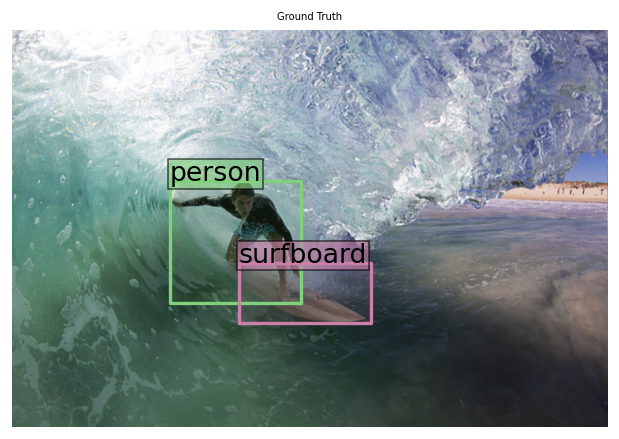

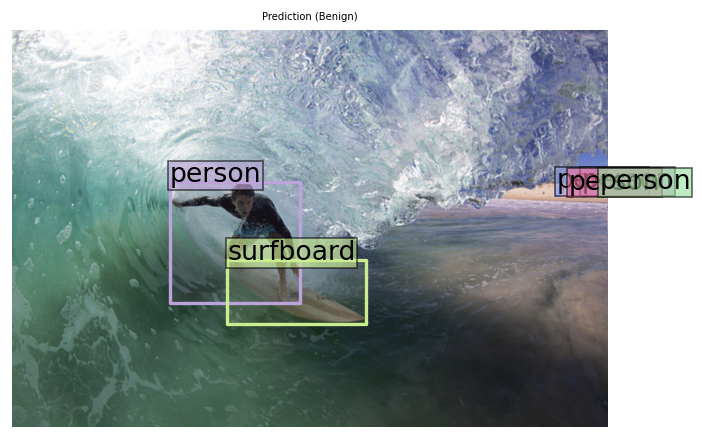

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.018635303..1.0189667].


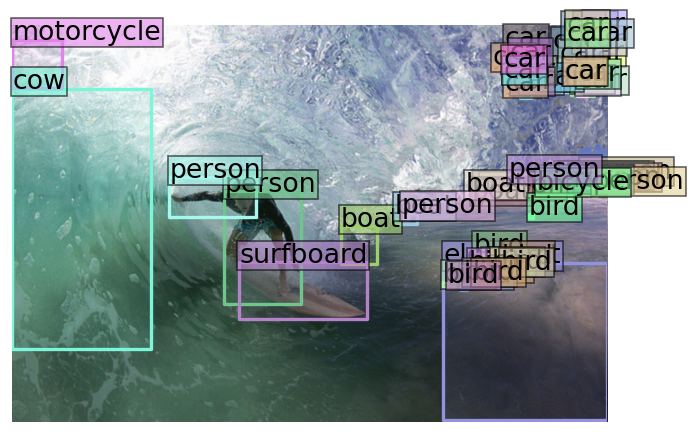

[(1.0, 1.0), (2.3497867915733286, -0.04792055913278248), (2.3206046763970214, -0.07182318582125397), (2.717099356620234, -0.5186716937485893), (2.9293725121701977, -0.5851782959064309), (3.4344354383988294, -0.8853684835265132), (3.6564840376393093, -0.8814095906082954), (3.832609278551231, -0.8808048449423967), (4.031503778455141, -0.8823140193229038), (4.20044488403397, -1.712885238089742)]


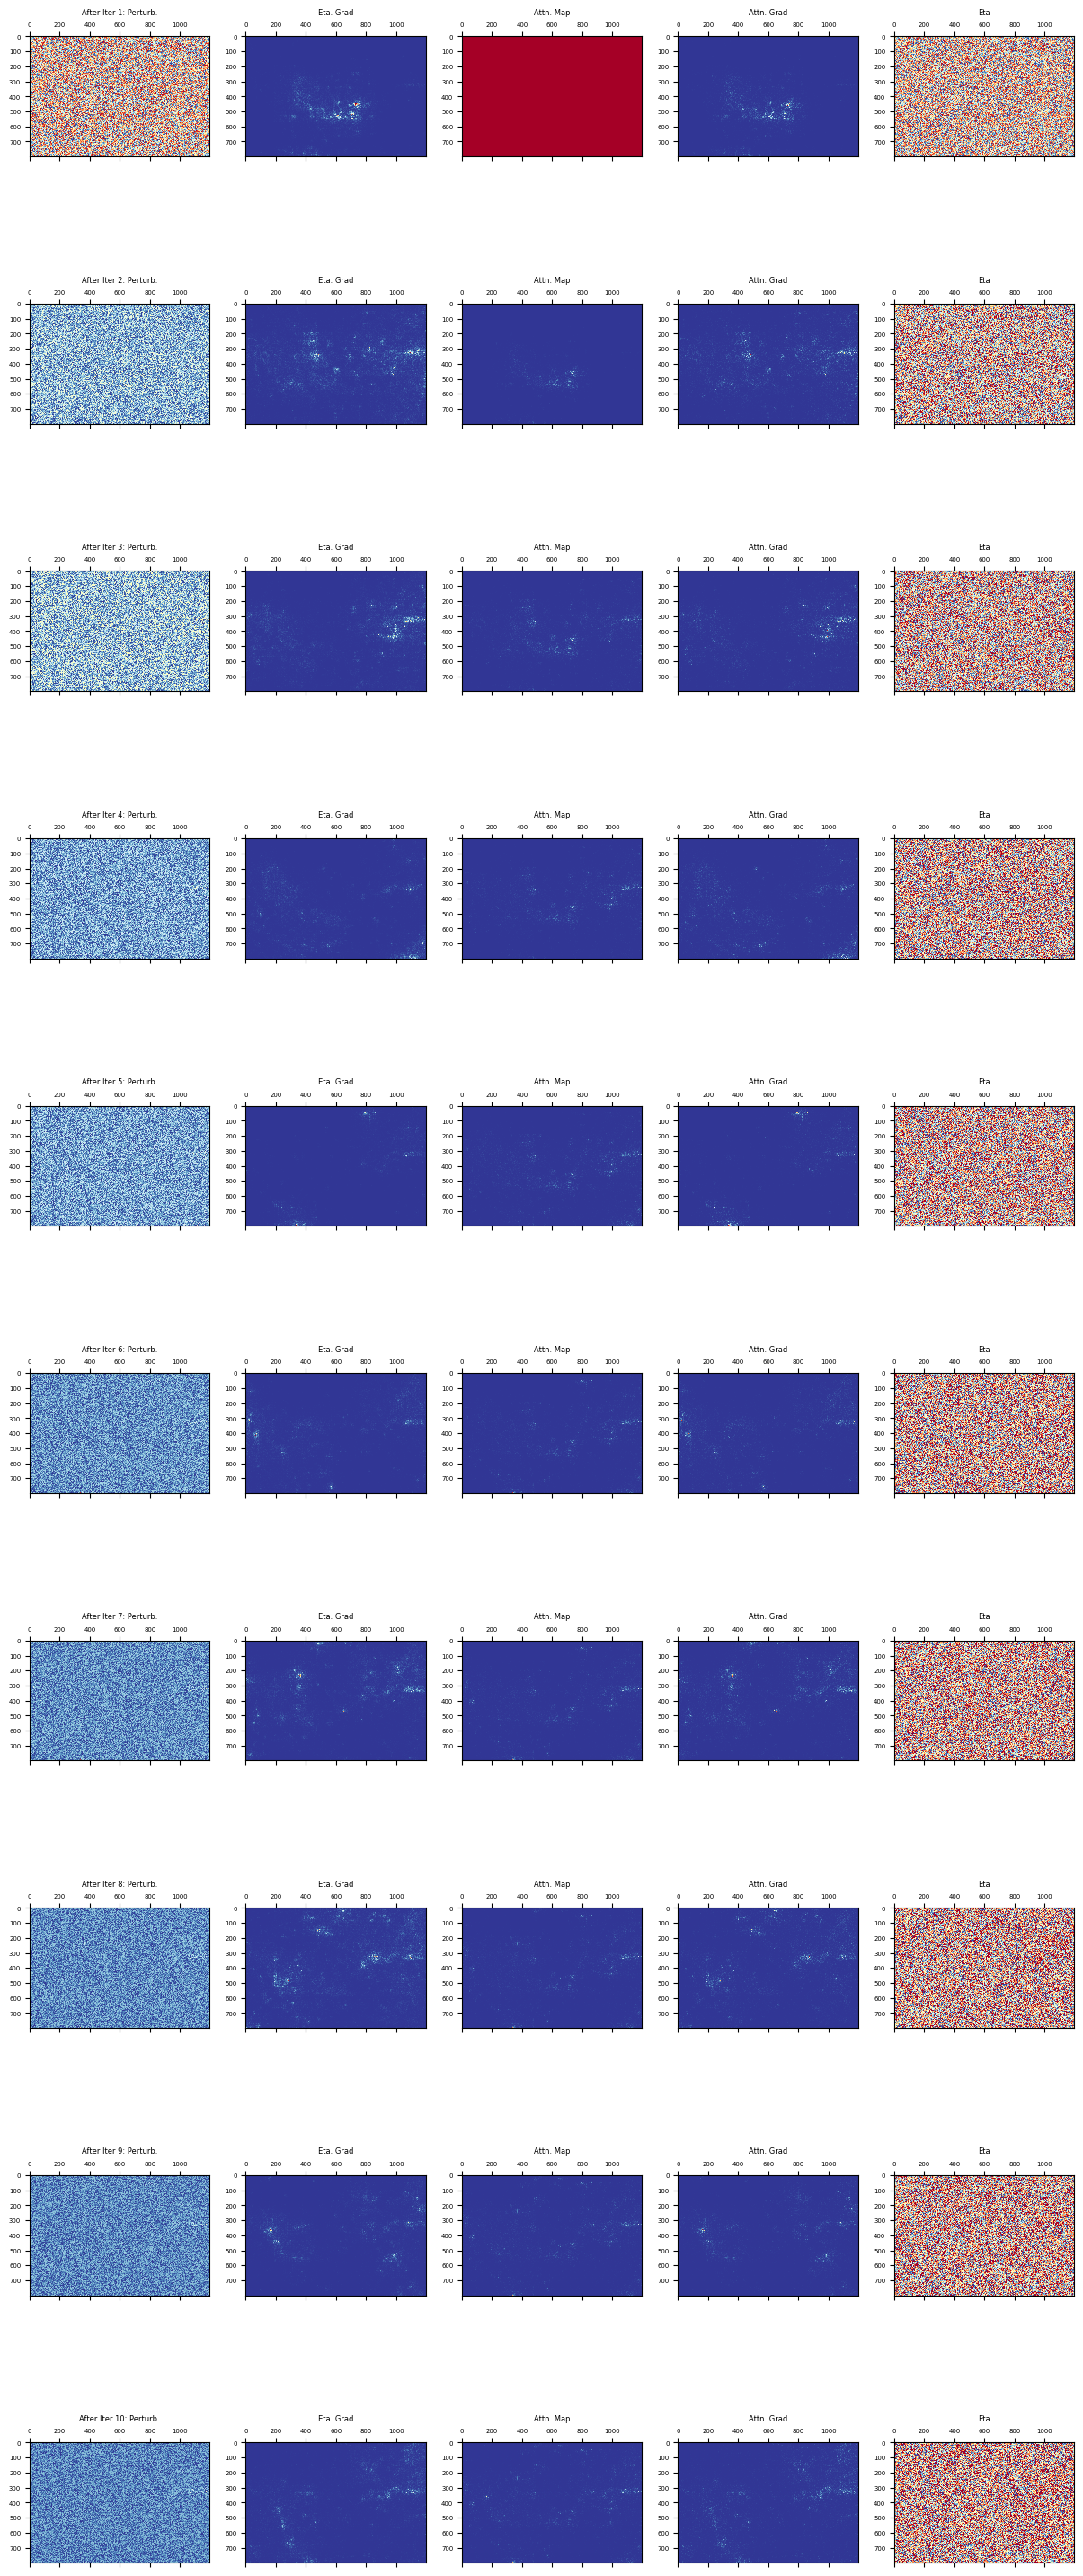

(1, 3, 800, 1199)


In [21]:
image, targets = dataset_val[300]
print("--- Image ID:", targets["image_id"][0].item(), "---")
viz_gt(image, targets)
viz_preds(model, image, targets, caption="Prediction (Benign)")

from afog.attacks import *
image_unt = afog(model, image.unsqueeze(0).float(), n_iter=10, mode="baseline")
# image_van = tog_attention(model, image.unsqueeze(0).float(), n_iter=10, mode="vanishing")
# image_fab = tog_attention(model, image.unsqueeze(0).float(), n_iter=10, mode="fabrication")
#image_untarget = tog_untargeted(model, image.unsqueeze(0).float(), n_iter=10)

viz_preds(model, image_unt.squeeze().float(), targets, caption="")
# viz_preds(model, image_van.squeeze().float(), targets, caption="")
# viz_preds(model, image_fab.squeeze().float(), targets, caption="")
#viz_preds(model, image_untarget.squeeze().float(), targets, caption="Prediction (TOG-Untarget)")

#image, targets = dataset_val[0]
visualize_attack(model, image, targets, afog, "baseline", n_iter=10)
%matplotlib inline

In [ ]:
# -- Image 3 ---
# attn_bbox_loss = [0.80, 0.80, 0.80, 0.52, 0.41, 0.85, 0.38, 0.80, 1.67, 0.84]
# unt_bbox_loss = [0.79, 0.80, 0.80, 0.80, 0.85, 0.85, 0.80, 0.61, 0.85, 1.68]

# attn_class_loss = [0.16, 2.04, 6.28, 11.58, 14.16, 17.85, 21.91, 22.75, 19.88, 25.95]
# unt_class_loss = [0.16, 1.99, 5.55, 10.38, 13.95, 15.07, 19.60, 22.28, 23.52, 23.59]

# --- Image 0 ---                
# attn_bbox_loss = [0.94, 0.96, 1.14, 1.09, 1.06, 1.08, 1.12, 1.10, 1.05, 0.96]
# unt_bbox_loss = [0.92, 1.01, 1.02, 1.08, 1.10, 1.17, 1.16, 1.04, 1.14, 1.18]

# attn_class_loss = [0.60, 1.03, 1.01, 1.45, 1.78, 2.15, 2.10, 2.40, 2.61, 3.24]
# unt_class_loss = [0.59, 0.82, 1.09, 1.44, 1.53, 1.53, 1.98, 2.57, 2.53, 2.76]

                
# --- Image 2 ---
attn_bbox_loss = [0.81, 0.83, 0.96, 0.94, 0.81, 0.97, 0.99, 0.96, 1.0, 0.91]
unt_bbox_loss = [0.81, 0.79, 0.91, 0.89, 0.97, 0.84, 1.01, 1.037, 0.99, 1.02]

attn_class_loss = [0.46, 0.96, 1.22, 1.88, 2.92, 2.72, 3.45, 3.67, 3.51, 4.25]
unt_class_loss = [0.47, 1.1, 1.37, 1.83, 2.43, 3.22, 3.48, 3.52, 4.06, 4.20]

plt.plot(attn_bbox_loss)
plt.xlabel("Iteration", fontsize=12)
plt.plot(unt_bbox_loss)
plt.ylabel("bbox Loss", fontsize=12)
plt.legend(["Attention", "Untarget"], fontsize=8)
plt.grid()
plt.show()

plt.plot(attn_class_loss)
plt.xlabel("Iteration", fontsize=12)
plt.plot(unt_class_loss)
plt.ylabel("class Loss", fontsize=12)
plt.legend(["Attention", "Untarget"], fontsize=8)
plt.grid()
plt.show()

In [ ]:
# adapted from https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_attention.ipynb#scrollTo=eg4RK8JiYTEl
import torchvision.transforms as T
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32).cuda()
    return b

def visualize_decoder_weights(model, img):
    transform = T.Compose([
        T.Resize(800),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
    # mean-std normalize the input image (batch-size: 1)
    #img = transform(im).unsqueeze(0)

    # propagate through the model
    outputs = model(img.unsqueeze(0).cuda())

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.9

    # convert boxes from [0; 1] to image scales
    print("Size is", img.shape)
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], (img.shape[1], img.shape[2]))
    
    # use lists to store the outputs via up-values
    conv_features, enc_attn_weights, dec_attn_weights = [], [], []

    hooks = [
        model.backbone[-2].register_forward_hook(
            lambda self, input, output: conv_features.append(output)
        ),
        model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
            lambda self, input, output: enc_attn_weights.append(output[1])
        ),
        model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
            lambda self, input, output: dec_attn_weights.append(output[1])
        ),
    ]

    for hook in hooks:
        hook.remove()

    # don't need the list anymore
    conv_features = conv_features[0]
    enc_attn_weights = enc_attn_weights[0]
    dec_attn_weights = dec_attn_weights[0]
    
    # get the feature map shape
    h, w = conv_features['0'].tensors.shape[-2:]

    fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=2, figsize=(22, 7))
    colors = COLORS * 100
    for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
        ax = ax_i[0]
        ax.imshow(dec_attn_weights[0, idx].view(h, w))
        ax.axis('off')
        ax.set_title(f'query id: {idx.item()}')
        ax = ax_i[1]
        ax.imshow(img)
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color='blue', linewidth=3))
        ax.axis('off')
        ax.set_title(CLASSES[probas[idx].argmax()])
    fig.tight_layout()
    
    

In [ ]:
image, targets = dataset_val[1]
visualize_decoder_weights(model, image)